In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
%pylab inline
import scipy.sparse.linalg as LA
import scipy.special as special
import scipy.interpolate as interpolate

Populating the interactive namespace from numpy and matplotlib


# Periodic Lieb-Thirring

We study in these notes the periodic Lieb-Thirring inequality in dimension $d = 2$. The usual LT inequality is
$$
    L^N(\kappa) := \max_V \left\{ 
        \frac{ \sum_{n=1}^N | \lambda_n( - \Delta + V ) |^\kappa }{ \int | V |^{\kappa + 1} }
        \right\}.
$$
In order to have a periodic version of it, we restate the problem as follows. We write that
$$
    \left( \sum_{n=1}^N | \lambda_n( - \Delta + V ) |^\kappa \right)^{1/\kappa} 
    = \max_{\gamma \ge 0,  \| \gamma \|_{\mathfrak{S}_{\kappa'}} = 1  \atop {\rm rank} \gamma \le N} {\rm Tr} [- \Delta + V] \gamma
$$
with $\kappa' = \frac{\kappa}{\kappa - 1}$ and 
$$
    \| \gamma \|_{\mathfrak{S}_{\kappa'}} = {\rm Tr} \left( \gamma^{\kappa'} \right)^{1/{\kappa'}}.
$$
So
$$
    \left( L^{N}(\kappa) \right)^{1/\kappa} =
    \max_{\gamma, {\rm Tr} \left( \gamma^{\kappa'} \right) = 1}
    \max_{V} 
    \dfrac{{\rm Tr} [- \Delta + V] \gamma}{\left( \int | V |^{\kappa + 1} \right)^{1/\kappa}}.
$$


Now, every term admits a periodic setting equivalent. If we replace trace by trace-per-unit-volume, and integral by integral-per-cell, we get the following. Let $R$ be a lattice in $\mathbb{R^2}$, we are looking for
$$
    \boxed{ \left( L^{N}(\kappa) \right)^{1/\kappa} =
    \max_{\underline{{\rm Tr}} \left( \gamma^{\kappa'} \right) = 1}
    \max_{V} 
    \dfrac{ \underline{{\rm Tr}} [- \Delta + V] \gamma}{\left( \int_{\Gamma} | V |^{\kappa + 1} \right)^{1/\kappa}}. }
$$

## Scaling
If $R_a := a R$, then we can consider $V_a(x) := a^{-2} V(x/a)$, which is $R_a$ periodic, and we have
$$
    | \lambda_n(- \Delta_{R_a} + V_a)|^\kappa = a^{-2\kappa} | \lambda_n(- \Delta_R + V) |
$$
and
$$
    \int_{\Gamma_a} | V_a |^{\kappa + 1} = a^{-2 \kappa} \int_\Gamma | V |^{\kappa +1}.
$$
So it what follows, we may always assume $| \Gamma | = 1$ for instance (the size of the lattice does not matter). 

## Rank-1 operators
For rank-$1$ operators for instance, we write
$$
    \gamma = \int^\oplus_{\Gamma^*} \gamma_k dk, \quad \gamma_k = n_k | u_k \rangle \langle u_k |,
$$
and we have
$$
    \boxed{ 
        \left( L^{1}(\kappa) \right)^{1/\kappa} = \max \left\{ \dfrac{1}{\left( \int_{\Gamma} | V |^{\kappa + 1} \right)^{1/\kappa}} \dfrac{1}{| \Gamma^* |} \int_{\Gamma^*}   n_k \langle u_k, (- i \nabla + k)^2 + V ) u_k \rangle dk, \quad \dfrac{1}{| \Gamma^* |} \int_{\Gamma^*} n_k^{\kappa'} = 1 \right\}. }
$$

## reduced Brillouin zone
To compute the integral over $\Gamma^*$, we use symmetries to speed up the computations. We have
$$
    \dfrac{1}{| \Gamma^* |} \int_{\Gamma^*} f(k) dk = \dfrac{1}{K^2} \sum_{k \in rBZ} w_k f(k).
$$
rBZ is the reduced Brillouin zone for a $K \times K$ mesh, and $w_k$ is the weight of the point $k$. We expect the last Riemann sum to converge fast since it is an insulating system.

In [3]:
### Parameter of the lattice
#direct lattice, hexagonal
# a is chosen so that |\Gamma | = 1
a = sqrt(2/sqrt(3))
a1 = a*array([1,0])
a2 = a*array([1/2, sqrt(3)/2])

# dual lattice
v1 = 2*pi*array([1, -1/sqrt(3)])/a
v2 = 2*pi*array([0, 2/sqrt(3)])/a


print("volume of \Gamma = ", a1[0]*a2[1] - a1[1]*a2[0])
print("volume of \Gamma^* = ", v1[0]*v2[1] - v1[1]*v2[0], "should be 4 \pi^2 = ", 4*pi**2)

volume of \Gamma =  1.0
volume of \Gamma^* =  39.47841760435743 should be 4 \pi^2 =  39.47841760435743


### The Wigner Seitz cell

In [4]:
def get_WS(Nb = 50):
    #returns xWS and yWS
    #useful to plot things
    
    NNb = linspace(0, 1-1/Nb, Nb)
    xgrid, ygrid = meshgrid(NNb, NNb)

    xWS = xgrid*a1[0] + ygrid*a2[0]
    yWS = xgrid*a1[1] + ygrid*a2[1]
    return xWS, yWS

def draw_WS():
    path1 = array([0*a1, a1, a1+a2, a2, 0*a2])
    path2 = array([a1, a2])
    plot(path1[:,0], path1[:,1], 'k')
    plot(path2[:,0], path2[:,1], 'k')

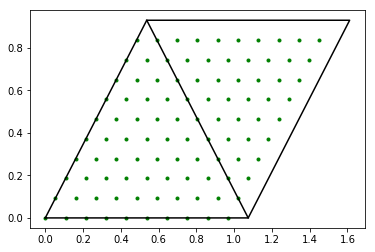

In [5]:
xWS, yWS = get_WS(10)
_ = plot(xWS, yWS, '.g')
draw_WS()

### We encode several transformations
We need the reflection about the $y$ axis $\tau: (x,y) \mapsto (-x, y)$ and the rotation $R$. We do not need the inversion $(x,y) \mapsto (-x, -y)$, as it is encoded with the conjugate.

In [6]:
# reflection
# transforms a1 --> -a1 and a2 --> a2 - a1
def tau(u):
    # u is defined on the WS grid
    Nb = shape(u)[0]
    newu = zeros((Nb,Nb))
    for i in range(Nb):
        for j in range(Nb):
            newu[i,j] = u[-(i+j)%Nb, j]
    return newu

In [7]:
# rotation by \pi/3 
# transforms a1 --> a2 and a2 --> (a2 - a1).
def rotate(u):
    Nb = shape(u)[0]
    newu = zeros((Nb, Nb))
    for i in range(Nb):
        for j in range(Nb):
            newu[i,j] = u[-j%Nb, (i+j)%Nb]
    return newu

In [8]:
def average_transform(u): #returns the average of all 12 transformations
    Nb = shape(u)[0]
    
    newu = zeros((Nb, Nb)) # the first one
    newu += u
    
    
    Ru = zeros((Nb, Nb))
    Ru += u
    for i in range(1, 6): # the 6 rotations
        Ru = rotate(Ru)
        newu += Ru
    newu += tau(newu) # the reflection
    return newu/12

In [9]:
def show_rho(u, vmin = None):
    Nb = shape(u)[0]
    
    xWS, yWS = get_WS(Nb)
    
    xWS3 = zeros((3*Nb, 3*Nb))
    yWS3 = zeros((3*Nb, 3*Nb))
    u3 = zeros((3*Nb, 3*Nb))
    
    for i in range(3):
        for j in range(3):
            v = i*a1 + j*a2
            xWS3[j*Nb:(j+1)*Nb, i*Nb:(i+1)*Nb] = xWS+v[0]
            yWS3[j*Nb:(j+1)*Nb, i*Nb:(i+1)*Nb] = yWS+v[1]
            u3[i*Nb:(i+1)*Nb, j*Nb:(j+1)*Nb] = u
    
    if vmin == None:
        contourf(xWS3, yWS3, u3, cmap='afmhot_r', levels=100)
    else:
        contourf(xWS3, yWS3, u3, cmap='afmhot_r', levels=100, vmin = vmin)
    axis("equal")
    colorbar()

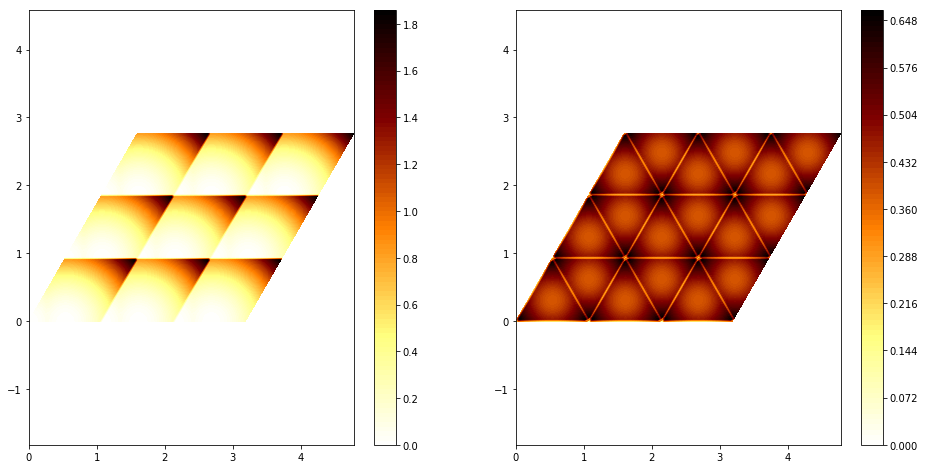

In [10]:
figsize(16, 8)
xWS, yWS = get_WS(30)

u = minimum(xWS, a2[0] - xWS)**2 + minimum(yWS, a1[1] - yWS)**2
newu = average_transform(u)

subplot(121)
show_rho(u)
    
subplot(122)
show_rho(newu)

### Construction of the reduced Brillouin zone, and the weight.

In [11]:
def get_rBZ(Nkpts):
    
    rBZ = []
    tol = 1e-8
    
    KK = linspace(0, 1-1/Nkpts, Nkpts)
    for k1 in KK:
        for k2 in KK:
            k = k1*v1 + k2*v2
            if k[0] > -tol and k[0] < k[1]/sqrt(3)+tol and k[1] < v2[1]/2+tol:
                rBZ.append(k)
    
    return array(rBZ)

In [12]:
def get_BZ(Nkpts):
    
    BZ = []
    tol = 1e-8
    
    KK = linspace(0, 1-1/(Nkpts), Nkpts)
    for k1 in KK:
        for k2 in KK:
            k = k1*v1 + k2*v2
            BZ.append(k)
    
    return array(BZ)

def draw_BZ():
    path1 = array([0*v1, v1, v1+v2, v2, 0*v2])
    path2 = array([v2/2, v2+(v1 - v2)/3, v2+2*(v1 - v2)/3, v1/2])
    path3 = array([v2+v1/2, v2+(v1 - v2)/3, v2+2*(v1 - v2)/3, v1+v2/2])
    plot(path1[:,0], path1[:,1], 'k')
    plot(path2[:,0], path2[:,1], ':k')
    plot(path3[:,0], path3[:,1], ':k')

size rBZ =  12


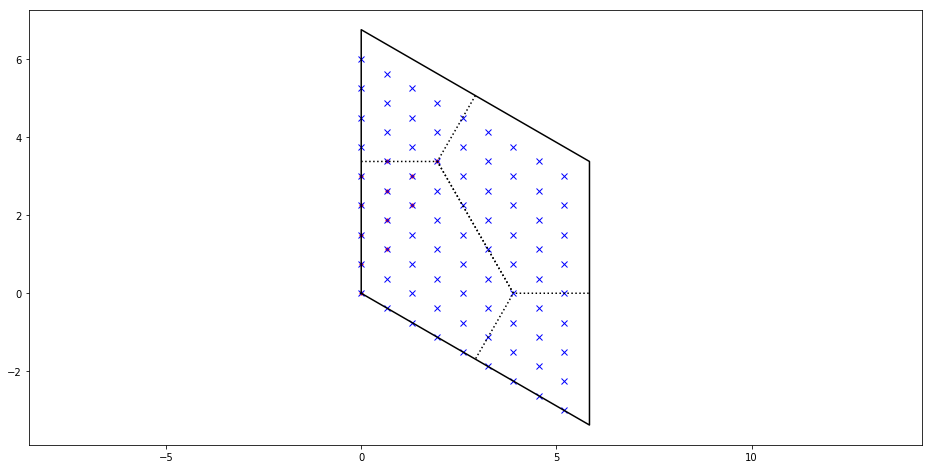

In [13]:
Nkpts = 9
rBZ = get_rBZ(Nkpts)
BZ = get_BZ(Nkpts)
plot(rBZ[:, 0], rBZ[:, 1], '.r')
plot(BZ[:, 0], BZ[:, 1], 'xb')
axis('equal')
print("size rBZ = ", shape(rBZ)[0])

draw_BZ()

In [14]:
def get_weights(rBZ):
    weights = []
    tol = 1e-7
    for k in rBZ:
        # first the special points
        if norm(k) < tol: #the center point
            weights.append(1)
        elif norm(k - v2-(v1 - v2)/3) < tol: # the "corner" of the BZ
            weights.append(2)
        elif norm(k - v2/2) < tol: # the "middle segment" of the BZ
            weights.append(3)
        elif abs(k[0]) < tol: # the horizontal line
            weights.append(6)
        elif abs(k[1] - sqrt(3)*k[0]) < tol: # the "diagonal" line
            weights.append(6)
        elif abs(k[1] - v2[1]/2) < tol: # the upper line
            weights.append(6)
        else:
            weights.append(12)
    Nkpts_square = sum(weights)
    return weights/Nkpts_square #(normalisation)

In [15]:
Nkpts = 7
rBZ = get_rBZ(Nkpts)
weights = get_weights(rBZ)
print("With Nkpts**2 = ", Nkpts**2, " rBZ contains %d points"%shape(rBZ)[0])
print("sum weights = ", sum(weights), "should be ", 1)
print("weights = ", weights)

With Nkpts**2 =  49  rBZ contains 8 points
sum weights =  1.0 should be  1
weights =  [0.02040816 0.12244898 0.12244898 0.12244898 0.12244898 0.24489796
 0.12244898 0.12244898]


# The Hamiltonian Hk

### The kinetic energy $\Delta_k$.

A function $f$ which is $R$-periodic has a Fourier transform of the form
$$
    f(x) = \frac{1}{|\Gamma |^{1/2}} \sum_{k \in R^*} \hat{f}(k) \exp(i k x),
    \quad \text{with} \quad
    \hat{f}(k) = \frac{1}{| \Gamma |^{1/2}} \int_{\Gamma} f(x) \exp(- i k x) dx
$$
In our case, since $R$ is a hexagonal lattice, $R^*$ is hexagonal as well.

In [16]:
def get_mDelta_k(k, Nb): 
    # return (- i \nabla + k)^2 in Fourier
    # The operation is diagonal in Fourier
    # This is the multiplication by kinetic_q 
    
    #############################
    # Construction of _kinetic_k
    #############################
    KK = linspace(0, Nb-1, Nb) #  integers coefficients
    xgrid, ygrid = meshgrid(KK, KK)
    
    k1 = xgrid*v1[0] + ygrid*v2[0]
    k2 = xgrid*v1[1] + ygrid*v2[1]
    
    # Careful about periodicity... We need to take the minimum of 4 matrices
    A1 = (k1 - k[0])**2 + (k2 - k[1])**2
    A2 = (k1 - k[0] - Nb*v1[0])**2 + (k2 - k[1] - Nb*v1[1])**2
    A3 = (k1 - k[0] - Nb*v2[0])**2 + (k2 - k[1] - Nb*v2[1])**2
    A4 = (k1 - k[0] - Nb*(v1+v2)[0])**2 + (k2 - k[1] - Nb*(v1+v2)[1])**2

    _kinetic_k = minimum( minimum(A1, A2), minimum(A3, A4))
    
    def mult_mDelta(ul):
        u = reshape(ul, (Nb,Nb))
        U = ifft2(u)
        mDeltaU = _kinetic_k*U
        mdeltau = fft2(mDeltaU)
        return reshape(mdeltau, Nb**2)
    return LA.LinearOperator((Nb**2, Nb**2), matvec = mult_mDelta)

In [17]:
# We compute the matrices -\Delta_k once for all for all points in the BZ.

def get_list_mDeltak(rBZ, Nb):
    list_mDeltak = []

    for k in rBZ:
        mDeltak = get_mDelta_k(k, Nb)
        list_mDeltak.append(mDeltak)
    return mDeltak

In [18]:
%%time

list_mDeltak = get_list_mDeltak(rBZ, 50)

CPU times: user 10.8 ms, sys: 2.75 ms, total: 13.6 ms
Wall time: 12.4 ms


In [19]:
%%time
k = [0,0]
Nb = 30

H = get_mDelta_k(k, Nb)
w, v = LA.eigsh(H, 10, v0 = ones(Nb**2), which='SA')

CPU times: user 829 ms, sys: 147 ms, total: 976 ms
Wall time: 1.13 s


w =  [1.77493704e-29 4.55857501e+01 4.55857501e+01 4.55857501e+01
 4.55857501e+01 4.55857501e+01 4.55857501e+01 1.36757250e+02
 1.36757250e+02 1.36757250e+02]


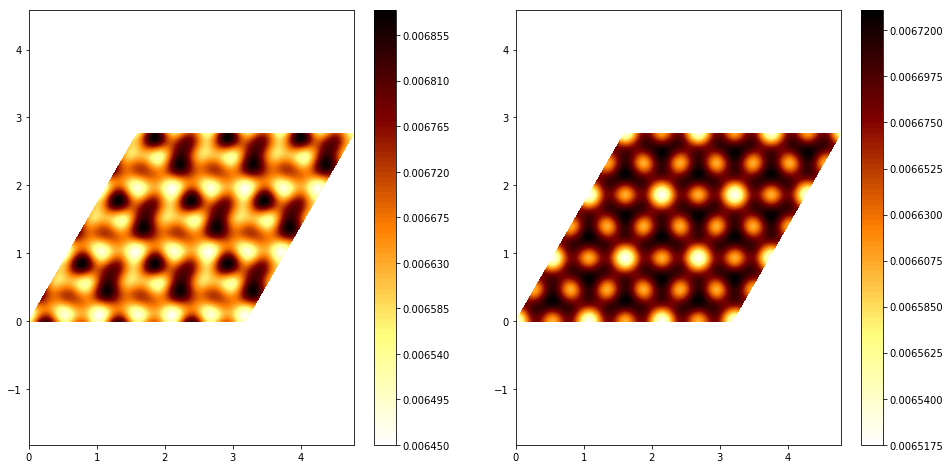

In [20]:
print("w = ", w)

rho = zeros((Nb, Nb))

for i in [1,2,3,4,5, 6]:
    ul = v[:, i]
    u = reshape(ul, (Nb, Nb))
    rho += abs(u)**2

subplot(121)
show_rho(rho)
subplot(122)
show_rho(average_transform(rho))

### The potential energy is much simpler. It is directly diagonal

In [21]:
def get_Vop(V): # V is a L \times L (real) function on the direct space
    def mult_V(ul):
        u = reshape(ul, (Nb, Nb))
        Vu = V*u
        return reshape(Vu, Nb**2)
    return LA.LinearOperator((Nb**2, Nb**2), matvec = mult_V)

Recall that
$$
    \left( L^{N}(\kappa) \right)^{1/\kappa} =
    \max_{\underline{{\rm Tr}} \left( \gamma^{\kappa'} \right) = 1}
    \max_{V} 
    \dfrac{ - \underline{{\rm Tr}} [- \Delta + V] \gamma}{\left( \int_{\Gamma} | V |^{\kappa + 1} \right)^{1/\kappa}}
    = 
    \max_{V} 
    \max_{\underline{{\rm Tr}} \left( \gamma^{\kappa'} \right) = 1}
    \dfrac{ - \underline{{\rm Tr}} (- \Delta  \gamma) - \int_{\Gamma} V \rho_{\gamma}}{\left( \int_{\Gamma} | V |^{\kappa + 1} \right)^{1/\kappa}}
$$

Once $\rho$ is fixed, the best $V$ is of the form
$$
    V(x) =  - \beta\rho^{1/\kappa}(x) \quad \text{for some} \quad \beta > 0.
$$
But what is $\beta$?  We have
$$
    L^{1/\kappa} = \max_{\gamma \ge 0 \atop \| \gamma \|_q = 1} \max_{V} \dfrac{- {\rm Tr} ([- \Delta + V] \gamma)}{\left( \int V^{\kappa + 1} \right)^{1/\kappa}} 
    = \max_{\gamma \ge 0 \atop \| \gamma \|_q = 1} \max_{\beta} \dfrac{- {\rm Tr} (- \Delta \gamma) + \beta \int \rho^{1 + 1/\kappa}}{ \beta^{1 + 1/\kappa} \left(\int \rho^{1 + 1/\kappa} \right)^{1/\kappa}}.
$$
Optimising in $\beta$ gives
$$
    \boxed{ \beta = (\kappa + 1) \dfrac{ \underline{{\rm Tr}} (- \Delta \gamma)}{\int_{\Gamma} \rho^{1 + 1/\kappa}}. }
$$

In [22]:
def get_V_LT(rho, kappa, KE):
    # KE is the kinetic energy \Tr(-\Delta \gamma)
    Nb = shape(rho)[0]
    I = sum(rho**(1 + 1/kappa))/Nb**2
    print("I = ", I)
    beta = (kappa+1)*KE/I
    print("beta = ", beta)
    return - beta*rho**(1/kappa)

### The Hamiltonian $H_k$

In [23]:
def get_H_LT(k, V):
    Nb = shape(V)[0]
    mDeltak = get_mDelta_k(k, Nb)
    Vop = get_Vop(V)
    return mDeltak + Vop

## The optimisation procedure

In [24]:
# The semi-classical Lieb-Thirring constant
def get_Lsc(kappa):
    return 1/(4*np.pi)*special.gamma(kappa+1)/special.gamma(kappa+2) #semi classical cst

On the other hand, the best $\gamma$ is of the form
$$
    \gamma = \int^{\oplus}_{\Gamma^*} \gamma_k d k, \quad \text{with} \quad \gamma_k = \frac{1}{Z} | \lambda_k |^{\kappa - 1} | u_k \rangle \langle u_k |,
$$
where $\lambda_k$ is the first eigenvalue of $H_k$, and where
$$
    Z := \left(\dfrac{1}{| \Gamma^* |}\int {| \lambda_k |^\kappa}
    \right)^{1/{\kappa'}}.
$$

In [25]:
def update_V(V, kappa, rBZ, weights, nbands = 1):
    # rho is the previous density
    # kappa is the power
    # oldL is the previous L
    # for the integration in the BZ, we need rBZ and weights
    #######################################
    # The algorithm returns (new_rho, L, Nel)
    # new_rho is the updated rho
    # L is the previous integral
    # Nel is the number of particles per cell (integer if isolated band)
    # vap is an array of size nbands x | rBZ | and contain the eigenvalues
    #######################################

    Nb = shape(V)[0]
    
    L = 0 # \sum | \lambda_1 |^\kappa / \int V^{1 + \kappa}
    KE = 0
    Nel = 0
    rho = np.zeros((Nb,Nb))
    vap = np.zeros((nbands, shape(rBZ)[0]))

    u0 = ones(Nb**2)/Nb # for the starting guess of the Hamiltonian
    for ik in range(shape(rBZ)[0]):
        k = rBZ[ik, :]
        wk = weights[ik]
        
        H = get_H_LT(k, V)
        W, U = LA.eigsh(H, nbands, v0 = u0, which='SA')
        vap[:, ik] = W # compute all eigenvalues for the final normalisation

        for i in range(nbands):
            lambdai = W[i]
            if lambdai < 0: # check that lambdai < 0
                # we add the vector ui
                Nel += wk
                L += wk*abs(lambdai)**kappa
                
                ul = U[:,i]
                u = reshape(ul, (Nb, Nb))
                rho += wk * abs(lambdai)**(kappa-1) * average_transform(abs(u)**2)
                # kinetic energy
                mDeltak = get_mDelta_k(k, Nb)
                vl = mDeltak.dot(ul)
                KE += wk * abs(lambdai)**(kappa-1) * real( dot(conj(ul), vl.T) )
    
    # normalisation for the integration
    # at this point, we have L = \sum_k w_k | \lambda_i |^\kappa (as wanted)
    Z = L**(1 - 1/kappa)
    rho /= Z
    KE /= Z

    IntV = sum( abs(V)**(kappa + 1) )/Nb**2 #the integral of V, for LT
    L /= IntV
    IntRho = sum( abs(rho)**(1 + 1/kappa))/Nb**2 #the integral of rho
    
    print("kinetic = ", KE)
    print("IntV = ", IntV)
    print("IntRho = ", IntRho)
    print("L = ", L)
    print("Nel = ", Nel)
    newV = get_V_LT(rho, kappa, KE)
    
    return newV, rho, L, Nel, vap

In [28]:
V1, rho1, L1, Nel1, vap1 = update_V(-10*ones((Nb, Nb)), 1.2, rBZ, weights, nbands = 5)

kinetic =  3.373403568544474
IntV =  158.48931924611142
IntRho =  2.3711269165653736e-06
L =  0.03650936033437941
Nel =  0.7551020408163265
I =  2.3711269165653736e-06
beta =  3129941.210210722


In [ ]:
show_rho(V1)

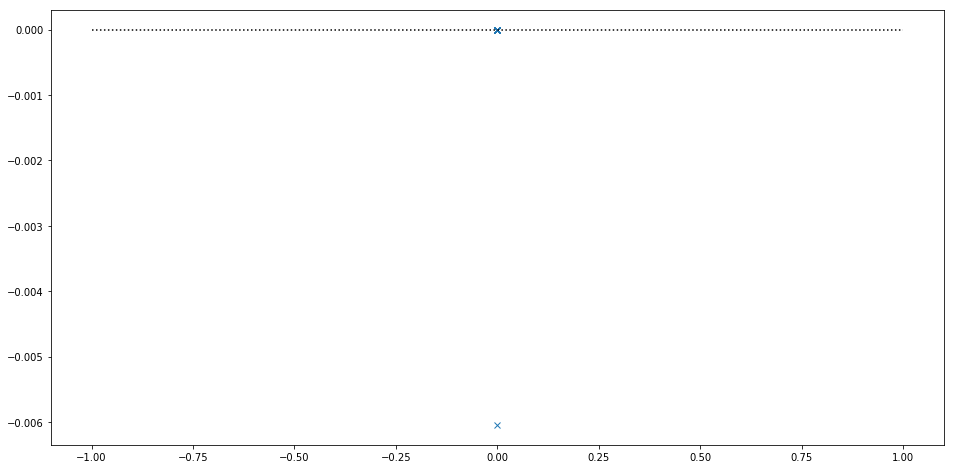

In [82]:
nbands, NrBZ = shape(vap)
for iq in range(nbands):
    plot(zeros(NrBZ), vap[iq,:], 'x')
plot([-1, 1], [0, 0], ':k')

In [122]:
def find_best_V(V0, kappa, Nkpts = 5, nbands = 2, tol = 1e-4, Niter = 10):
    Lsc = get_Lsc(kappa) #for initialisation of L, and to compare
    
    Vn = V0
    L = 0
    
    rBZ = get_rBZ(Nkpts)
    weights = get_weights(rBZ)

    print("_____________________________")
    print("find_best_rho")
    print("_____________________________")
    
    for i in range(Niter):
        Vn, rhon, L, Nel, vap = update_V(Vn, kappa, rBZ, weights, nbands)

        R = L/Lsc # we now that R \ge 1
        
        print("Iteration i = %d,\t Nel = %f, \t L = %f,\t L/Lsc = %f"%(i, Nel, L, R))

        # we want to increase the ratio
        if L < Ln + tol:
            return Vn, rhon, L, Nel, vap
        Ln = L
    return Vn, rhon, L, Nel, vap

### Test

In [70]:
Nb = 30
kappa = 1.3
Nkpts = 9
tol = 1e-6
Niter = 10
nbands = 1

Lsc = get_Lsc(kappa)
print("Lsc = ", Lsc)

rho0 = np.load("rho0.npy", allow_pickle=True).item()["rho"]
V0 = -2000*rho0**(1/kappa)

rBZ = get_rBZ(Nkpts)
weights = get_weights(rBZ)

Lsc =  0.03459890067215117


In [124]:
V1, rho1, L1, Nel1, vap1 = update_V(V0, kappa, rBZ, weights, nbands)

TypeError: unsupported operand type(s) for +=: 'int' and '_ScaledLinearOperator'

# Old Test

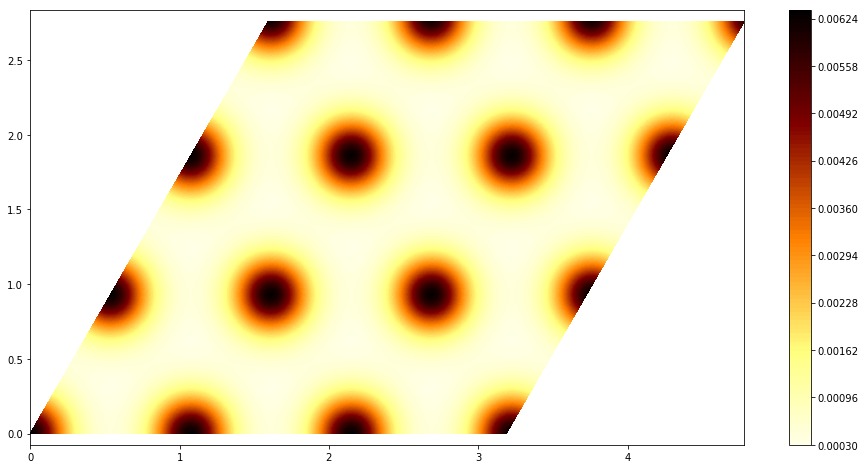

In [88]:
# rho0
Nb = 30
rho0 = np.load("rho0.npy", allow_pickle=True).item()["rho"]
show_rho(rho0, vmin = 0)

In [49]:
# Hexagonal start for N = 3
#rho0 = load("rho0_1165_N3_2.npy", allow_pickle = True).item()["rho"]
#show_rho(rho0)

In [50]:
# Hexagonal start for N = 2
#rho0 = load("rho0_1165_N3_2.npy", allow_pickle = True).item()["rho"]
#rho0[0:Nb//5, 0:Nb//5] = 0
#rho0[4*Nb//5:, 4*Nb//5:] = 0
#rho0[0:Nb//5, 4*Nb//5:] = 0
#rho0[4*Nb//5:, 0:Nb//5] = 0
#rho0 = average_transform(rho0)
#show_rho(rho0)

## Small value of kappa

In [89]:
kappa = 1.8
Nkpts = 9
tol = 1e-6
Niter = 10
nbands = 1

Lsc = get_Lsc(kappa)
print("Lsc = ", Lsc)

Lsc =  0.028420525552124168


In [95]:
kappa = 1.1
V = get_V_LT(rho0, kappa, Lsc)
sum(abs(V)**(kappa+1))/Nb**2

200086187.90006238

In [86]:
rhon, Ln, Nel, vap = find_best_rho(rhon, kappa, Nkpts, nbands, tol, Niter)
print("Done. Minimum rho = ", min(reshape(rhon, Nb*Nb)))

_____________________________
find_best_rho
_____________________________
Iteration i = 0,	 Nel = 1.000000, 	 L = 0.000078,	 L/Lsc = 0.002361
Iteration i = 1,	 Nel = 1.000000, 	 L = 0.000000,	 L/Lsc = 0.000006
Done. Minimum rho =  0.0011111111111109958


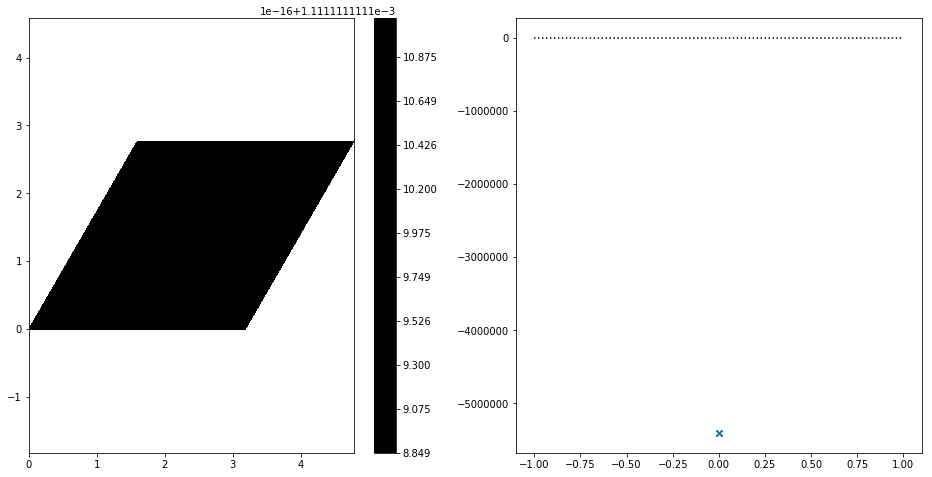

In [87]:
figsize(16, 8)
subplot(121)
show_rho(rhon, vmin=0)

subplot(122)
nbands, NrBZ = shape(vap)
for iq in range(nbands):
    plot(zeros(NrBZ), vap[iq,:], 'x')
plot([-1, 1], [0, 0], ':k')

In [0]:
rhon_saved= rhon

In [0]:
#optimise in I
tol = 1e-6
II = linspace(4000, 10000, 10)
Lrecord = []
rhorecord = []

best_rhon = rhon
best_I = 0
best_L = 0

for I in II:
    rhon, L, Nel, vap = find_best_rho(rhon, kappa, I, Nkpts, nbands, tol, Niter)
    Lrecord.append(L)
    rhorecord.append(rhon)
    if L > best_L:
        best_rhon = rhon
        best_I = I
        best_L = L

        
print("best_I = ", best_I, ", \t best_L = ", best_L)
rhon = best_rhon
I = best_I

In [0]:
plot(II, Lrecord)

In [0]:
dico_1165 = {
    "kappa" : 1.165,
    "I" : I,
    "Nkpts" : Nkpts,
    "rho" : rhon,
}

print("saving")
print("kappa = ", dico_1165["kappa"])
print("I = ", dico_1165["I"])
print("Nkpts = ", dico_1165["Nkpts"])
save("rho0_1165_N2.npy", dico_1165)

In [0]:
rhon30 = rhon

# more test with high Nb

In [0]:
Nb = 60

tt = linspace(0, 1, 30)
tt_new = linspace(0, 1, Nb)

rhotemp = interpolate.RectBivariateSpline(tt, tt, rhon30)
rho0 = rhotemp(tt_new, tt_new)

show_rho(rho0)
print(shape(rho0))

In [0]:
kappa = 1.165
I = 10000
Nkpts = 9
tol = 1e-6
Niter = 10
nbands = 3

Lsc = get_Lsc(kappa)
print("Lsc = ", Lsc)

In [0]:
rhon, Ln, Nel, vap = find_best_rho(rho0, kappa, I, Nkpts, nbands, tol, Niter)

In [0]:
#display rho
figsize(16, 8)
subplot(121)
show_rho(rhon, vmin=0)

subplot(122)
nbands, NrBZ = shape(vap)
for iq in range(nbands):
    plot(zeros(NrBZ), vap[iq,:], 'x')
plot([-1, 1], [0, 0], ':k')

### Dichotomie for the best I

# ATTENTION, J'ai remis Nband = 1

# Free gas computation

In [0]:
V0 = get_V_LT(rho0, kappa, Itarget)
V0[0,0]

In [0]:
Itarget = 400
Nkpts = 20

rho0 = ones((Nb, Nb))
V = get_V_LT(rho0, kappa, Itarget)
V0 = V[0,0]
print("test avec V0 = ", V0, "et kappa = ", kappa)    
    
energy, Nel = f(Itarget, Nkpts)
Lsc = get_Lsc(kappa)
L = energy/Itarget
R = L/Lsc # we now that R \ge 1
print("Nel = %f,\t L = %f,\t L/Lsc = %f"%(Nel, L, R))
    

In [0]:
_kinetic

# plot figure

In [0]:
NNb = linspace(0, Nb-1, Nb)

xgrid, ygrid = meshgrid(NNb, NNb)

xBZ = xgrid*a1[0] + ygrid*a2[0]
yBZ = xgrid*a1[1] + ygrid*a2[1]
contourf(xBZ, yBZ, rhon)

# Record

In [0]:
#rhon1000 = rhon
#rhon500 = rhon
#rhon300 = rhon

# Other test with N = 1, kappa = 1.5

In [0]:
kappa = 1.6
N = 1


# rho0
xx = linspace(0, 1, Nb)
yy = linspace(0, 1, Nb)
def f(x,y): return exp( -((x-1/2)**2 + (y-1/2)**2))
rho0 = array([[f(x,y) for x in xx] for y in yy])

In [0]:
Itarget = 1000
rhon, Ln = find_best_rho(rho0, kappa, N, Itarget, Niter = 10)

In [0]:
contourf(xBZ, yBZ, rhon)

In [0]:
band1, band2 = get_bands(rhon, kappa)

In [0]:
contourf(band1)

In [0]:
band1

# Old stuff, do not delete !

In [0]:
%%time
Nb = 50
_kinetic = zeros((Nb, Nb)) #represents integer

for m1 in range(Nb):
    for m2 in range(Nb):
        n1 = norm(m1*v1 + m2*v2)**2
        n2 = norm((m1-Nb)*v1 + m2*v2)**2
        n3 = norm(m1*v1 + (m2-Nb)*v2)**2
        n4 = norm((m1-Nb)*v1 + (m2-Nb)*v2)**2
        _kinetic[m1, m2] = min([n1, n2, n3, n4])


In [0]:
def get_kinetic_matrix(q, Nb = 50):
    # q in BZ is the Bloch number
    k1BZ, k2BZ = get_BZ(Nb)
    n1 = (k1BZ - q[0])**2 + (k2BZ - q[1])**2
    n2 = (k1BZ - q[0] - Nb*v1[0])**2 + (k2BZ - q[1] - Nb*v1[1])**2
    n3 = (k1BZ - q[0] - Nb*v2[0])**2 + (k2BZ - q[1] - Nb*v2[1])**2
    n4 = (k1BZ - q[0] - Nb*(v1+v2)[0])**2 + (k2BZ - q[1] - Nb*(v1+v2)[1])**2

    return minimum( minimum(n1, n2), minimum(n3, n4))

In [0]:
def free_gas(kappa, epsF, Itarget, Nkpts):
    # We work in grand canonic for simplicity, so epsF is needed
    # Nkpts is the number of Kpts per direction in the BZ.
    # a good choice should be \eps = 0
    Nbands = 7
    band1 = zeros((Nkpts, Nkpts)) 
    band2 = zeros((Nkpts, Nkpts))
    
    rho0 = ones((Nb, Nb))
    V = get_V_LT(rho0, kappa, Itarget)
    V0 = V[0,0]

    energy = 0 # the sum of \sum \lambda_n^\kappa
    Nel = 0

    kk1, kk2 = np.linspace(0, 1, Nkpts), np.linspace(0, 1, Nkpts)
    for ik1 in range(Nkpts):
        for ik2 in range(Nkpts):
            k1, k2 = kk1[ik1], kk2[ik2]
            
            k = k1*v1 + k2*v2
            _kinetic = reshape( get_kinetic_matrix(k), Nb**2)
            _kinetic.sort()
            band1[ik1, ik2] = _kinetic[0]
            band2[ik1, ik2]= _kinetic[1]
            
            for i in range(Nbands):
                if _kinetic[i] < V0:
                    energy += abs(_kinetic[i] - V0)**kappa
                    Nel += 1
    # end loop
    # Normalisation
    energy /= Nkpts**2
    Nel /= Nkpts**2
    L = energy/Itarget
    return L, Nel, band1, band2

In [0]:
def free_gas(Itarget, Nkpts):
    # We work in grand canonic for simplicity, so epsF is needed
    # Nkpts is the number of Kpts per direction in the BZ.
    # a good choice should be \eps = 0

    rho0 = ones((Nb, Nb))
    V = get_V_LT(rho0, kappa, Itarget)
    V0 = V[0,0]

    energy = 0 # the sum of \sum \lambda_n^\kappa
    Nel = 0

    kk1, kk2 = np.linspace(0, 1, Nkpts), np.linspace(0, 1, Nkpts)
    for k1 in kk1:
        for k2 in kk2:
            k = k1*v1 + k2*v2
            _kinetic = reshape( get_kinetic_matrix(k), Nb**2)
            _kinetic.sort()
            lambda0 = _kinetic[0]
            assert _kinetic[1] > V0, print("V0 = ", V0, " et lambda1 = ", _kinetic[1])

            if lambda0 - V0 < 0:
                energy += abs(lambda0 - V0)**kappa
                Nel += 1
    # end loop
    # Normalisation
    energy /= Nkpts**2
    Nel /= Nkpts**2

    return energy, Nel
